# Forecast to Power Tutorial

This tutorial will walk through the process of going from Unidata forecast model data to AC power using the SAPM.

Table of contents:
1. [Setup](#Setup)
2. [Load Forecast data](#Load-Forecast-data)
2. [Calculate modeling intermediates](#Calculate-modeling-intermediates)
2. [DC power using SAPM](#DC-power-using-SAPM)
2. [AC power using SAPM](#AC-power-using-SAPM)

This tutorial requires pvlib >= 0.6.0.

Authors:
* Derek Groenendyk (@moonraker), University of Arizona, November 2015
* Will Holmgren (@wholmgren), University of Arizona, November 2015, January 2016, April 2016, July 2016, August 2018

## Setup

These are just your standard interactive scientific python imports that you'll get very used to using.

In [230]:
# built-in python modules
import datetime
import inspect
import os

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl

try:
    import netCDF4
except:
    !pip install netCDF4
    import netCDF4

try:
    import siphon
except:
    !pip install siphon
try:
    import pvlib
except:
    !pip install pvlib
# finally, we import the pvlib library
from pvlib import solarposition, irradiance, atmosphere, pvsystem, temperature, inverter
from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 27.6 MB 1.5 MB/s 


/usr/local/lib/python3.7/dist-packages/pvlib/forecast.py:22: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


## Load Forecast data

pvlib forecast module only includes several models. To see the full list of forecast models visit the Unidata website:

http://www.unidata.ucar.edu/data/#tds

In [231]:
# Choose a location.
# Tucson, AZ
# latitude = 32.2
# longitude = -110.9
# tz =  'US/Mountain'

#For Dijon:
latitude = 47.3
longitude = 5
tz = "Europe/Paris"

Define some PV system parameters.

In [232]:
import pvlib
print(pvlib.__version__)

0.9.1


In [233]:
surface_tilt = 15
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.1

In [234]:
start = pd.Timestamp(datetime.date.today(), tz=tz) # today's date
end = start + pd.Timedelta(days=2) #possible 14
#

In [235]:
# Define forecast model
fm = GFS() 
#fm = NAM() #north american model
#fm = NDFD() # Ok but may be just for America --> Does not work for Dijon
#fm = RAP()  # north america --> does'nt work for Dijon
#fm = HRRR()  # not work even for US

In [236]:
# Retrieve data
forecast_data = fm.get_processed_data(latitude, longitude, start, end)

Let's look at the downloaded version of the forecast data.

In [237]:
#forecast_data.head()
#Global Horizontal (GHI) = Direct Normal (DNI) X cos(θ) + Diffuse Horizontal (DHI)
forecast_data

,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds
2022-03-03 01:00:00+01:00,3.618561,0.665580,0.000000,0.000000,0.000000,100.000000,91.599998,39.200001,65.000000
2022-03-03 04:00:00+01:00,2.894287,0.411984,0.000000,0.000000,0.000000,97.699997,85.900002,15.400000,63.000000
2022-03-03 07:00:00+01:00,4.649994,0.623526,0.000000,0.000000,0.000000,98.800003,92.300003,9.600000,61.099998
2022-03-03 10:00:00+01:00,9.092743,0.951889,142.081030,4.368486,140.307609,88.900002,88.599998,0.000000,3.300000
2022-03-03 13:00:00+01:00,16.054108,0.791948,380.016849,184.643512,271.631707,46.700001,46.500000,0.000000,1.700000
2022-03-03 16:00:00+01:00,12.850922,1.662586,253.068903,292.591487,143.748240,24.100000,21.799999,0.000000,1.700000
2022-03-03 19:00:00+01:00,7.934570,1.982855,0.000000,0.000000,0.000000,61.400002,60.200001,0.000000,2.000000
2022-03-03 22:00:00+01:00,4.281219,2.105582,0.000000,0.000000,0.000000,48.099998,48.000000,0.000000,0.000000
2022-03-04 01:00:00+01:00,2.610077,1.878242,0.000000,0.000000,0.000000,25.799999,25.600000,0.000000,0.000000
2022-03-04 04:00:00+01:00,0.550018,1.421556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


This is a ``pandas DataFrame`` object. It has a lot of great properties that are beyond the scope of our tutorials.

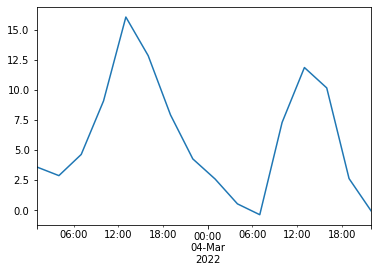

In [238]:
forecast_data['temp_air'].plot();

Plot the GHI data. Most pvlib forecast models derive this data from the weather models' cloud clover data.

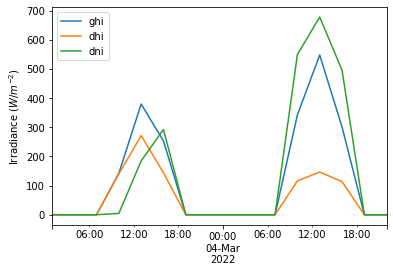

In [239]:
plt.figure()
ghi = forecast_data['ghi']
dhi = forecast_data['dhi']
dni = forecast_data['dni']
ghi.plot()
dhi.plot()
dni.plot()
plt.legend()
plt.ylabel('Irradiance ($W/m^{-2}$)');

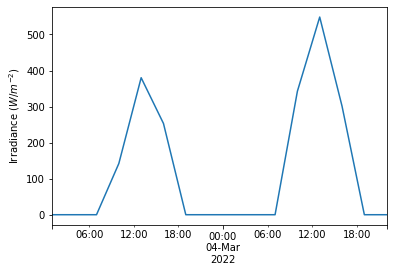

In [240]:
ghi = forecast_data['ghi']
ghi.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)');

## Calculate modeling intermediates

Before we can calculate power for all the forecast times, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

The approach here follows that of the pvlib tmy_to_power notebook. You will find more details regarding this approach and the values being calculated in that notebook.

### Solar position

Calculate the solar position for all times in the forecast data. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

In [241]:
# retrieve time and location parameters
time = forecast_data.index
a_point = fm.location
a_point

Location: 
  name: None
  latitude: 47.3
  longitude: 5
  altitude: 0
  tz: Europe/Paris

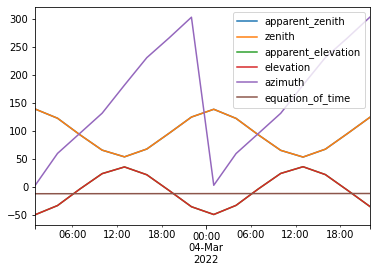

In [242]:
solpos = a_point.get_solarposition(time)
solpos.plot()

The funny looking jump in the azimuth is just due to the coarse time sampling in the TMY file.

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

Text(0, 0.5, 'Extra terrestrial radiation ($W/m^{-2}$)')

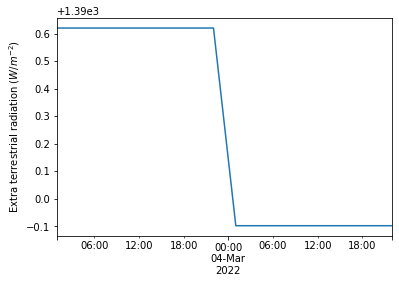

In [243]:
dni_extra = irradiance.get_extra_radiation(fm.time)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation ($W/m^{-2}$)')

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

Text(0, 0.5, 'Airmass')

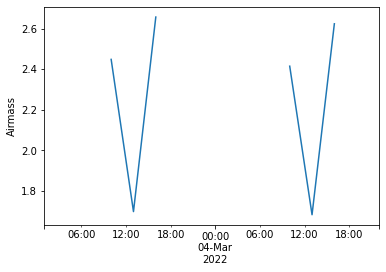

In [244]:
airmass = atmosphere.get_relative_airmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass')

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

Text(0, 0.5, 'Irradiance ($W/m^{-2}$)')

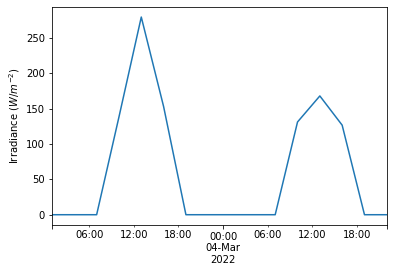

In [245]:
poa_sky_diffuse = irradiance.haydavies(surface_tilt, surface_azimuth,
                                       forecast_data['dhi'], forecast_data['dni'], dni_extra,
                                       solpos['apparent_zenith'], solpos['azimuth'])
poa_sky_diffuse.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

Text(0, 0.5, 'Irradiance ($W/m^{-2}$)')

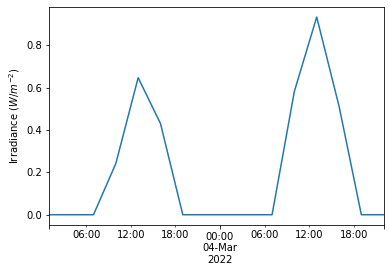

In [246]:
poa_ground_diffuse = irradiance.get_ground_diffuse(surface_tilt, ghi, albedo=albedo)

poa_ground_diffuse.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

### AOI

Calculate AOI

Text(0, 0.5, 'Angle of incidence (deg)')

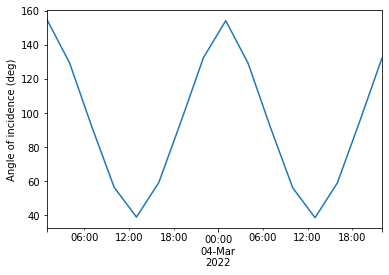

In [247]:
aoi = irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth'])

aoi.plot()
plt.ylabel('Angle of incidence (deg)')

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

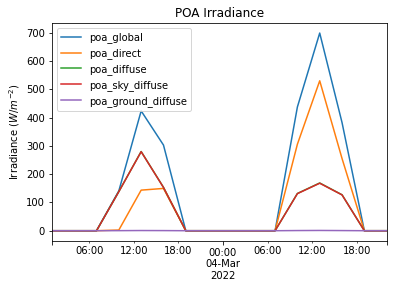

In [248]:
poa_irrad = irradiance.poa_components(aoi, forecast_data['dni'], poa_sky_diffuse, poa_ground_diffuse)

poa_irrad.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')
plt.title('POA Irradiance');

### Cell temperature

Calculate pv cell temperature

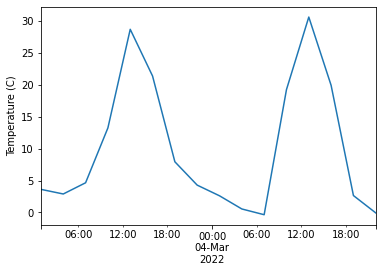

In [249]:
ambient_temperature = forecast_data['temp_air']
wnd_spd = forecast_data['wind_speed']
thermal_params = temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
pvtemp = temperature.sapm_cell(poa_irrad['poa_global'], ambient_temperature, wnd_spd, **thermal_params)

pvtemp.plot()
plt.ylabel('Temperature (C)');

## DC power using SAPM

Get module data from the web.

In [250]:
sandia_modules = pvsystem.retrieve_sam('SandiaMod')
sandia_modules

#A DataFrame containing all the elements of the desired database. Each column represents a module or inverter, and a specific dataset can be retrieved by the command

,Advent_Solar_AS160___2006_,Advent_Solar_Ventura_210___2008_,Advent_Solar_Ventura_215___2009_,Aleo_S03_160__2007__E__,Aleo_S03_165__2007__E__,Aleo_S16_165__2007__E__,Aleo_S16_170__2007__E__,Aleo_S16_175__2007__E__,Aleo_S16_180__2007__E__,Aleo_S16_185__2007__E__,AstroPower_AP_100___2001_,AstroPower_AP_100__2000__E__,AstroPower_AP_110___2001_,AstroPower_AP_110__1999__E__,AstroPower_AP_120___2001_,AstroPower_AP_120__1999__E__,AstroPower_AP_1206___1998_,AstroPower_AP_130___2001_,AstroPower_AP_130__2002__E__,AstroPower_AP_50___2001_,AstroPower_AP_50__2000__E__,AstroPower_AP_65__1999__E__,AstroPower_AP_75___2001_,AstroPower_AP_75___2003_,AstroPower_AP_75__2003__E__,AstroPower_AP_8225___1997_,AstroPower_APX_110_SL___2002_,AstroPower_APX_110_SL__2002__E__,AstroPower_APX_120___2001_,AstroPower_APX_120__2002__E__,AstroPower_APX_130___2001_,AstroPower_APX_130__2002__E__,AstroPower_APX_140__2002__E__,AstroPower_APX_40__2002__E__,AstroPower_APX_45___2001_,AstroPower_APX_45__1999__E__,AstroPower_APX_45__2002__E__,AstroPower_APX_50__2002__E__,AstroPower_APX_65___2001_,AstroPower_APX_65__2002__E__,...,Uni_Solar_PVL_116__2003__E__,Uni_Solar_PVL_124__2006__E__,Uni_Solar_PVL_128__2003__E__,Uni_Solar_PVL_136__2005__E__,Uni_Solar_PVL_29__2003__E__,Uni_Solar_PVL_58__2003__E__,Uni_Solar_PVL_64__2003__E__,Uni_Solar_PVL_68__2005__E__,Uni_Solar_PVL_87__2003__E__,Uni_Solar_SHR_17__2004__E__,Uni_Solar_US_11__2005__E__,Uni_Solar_US_116__2003__E__,Uni_Solar_US_21__2003__E__,Uni_Solar_US_3__2003__E__,Uni_Solar_US_32___1997_,Uni_Solar_US_32__1997__E__,Uni_Solar_US_32__2005__E__,Uni_Solar_US_42__2003__E__,Uni_Solar_US_5__2005__E__,Uni_Solar_US_64___1997_,Uni_Solar_US_64__1997__E__,Uni_Solar_US_64__2005__E__,Uni_Solar_USF_11__2003__E__,Uni_Solar_USF_32__2003__E__,Uni_Solar_USF_5__2003__E__,Yingli_Solar_YL220_Module___2008_,Yingli_Solar_YL220_Module__2008__E__,Yingli_Solar_YL230_29b_Module___2009_,Yingli_Solar_YL230_29b_Module__2009__E__,Yingli_YL210__2008__E__,Panasonic_VBHN235SA06B__2013_,Trina_TSM_240PA05__2013_,Hanwha_HSL60P6_PA_4_250T__2013_,Suniva_OPT300_72_4_100__2013_,Canadian_Solar_CS6X_300M__2013_,LG_LG290N1C_G3__2013_,Sharp_NDQ235F4__2013_,Solar_Frontier_SF_160S__2013_,SolarWorld_Sunmodule_250_Poly__2013_,Silevo_Triex_U300_Black__2014_
Vintage,2006,2008,2009,2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2001,2000 (E),2001,1999 (E),2001,1999 (E),1998,2001,2002 (E),2001,2000 (E),1999 (E),2001,2003,2003 (E),1997,2002,2002 (E),2001,2002 (E),2001,2002 (E),2002 (E),2002 (E),2001,1999 (E),2002 (E),2002 (E),2001,2002 (E),...,2003 (E),2006 (E),2003 (E),2005 (E),2003 (E),2003 (E),2003 (E),2005 (E),2003 (E),2004 (E),2005 (E),2003 (E),2003 (E),2003 (E),1997,1997 (E),2005 (E),2003 (E),2005 (E),1997,1997 (E),2005 (E),2003 (E),2003 (E),2003 (E),2008,2008 (E),2009,2009 (E),2008 (E),2013,2013,2013,2013,2013,2013,2013,2013,2013,2014
Area,1.312,1.646,1.646,1.28,1.28,1.378,1.378,1.378,1.378,1.378,0.974,0.974,0.974,0.974,0.974,0.974,0.974,1.12,1.12,0.567,0.567,0.631,0.631,0.633,0.633,0.974,1.485,1.485,1.72,1.72,1.72,1.72,1.72,0.657,0.657,0.566,0.657,0.657,0.955,0.955,...,1.982,1.973,2.168,2.161,0.555,1.027,1.121,1.121,1.502,0.669,0.188,1.868,0.355,0.0586,0.523,0.523,0.523,0.688,0.101,1.012,1.012,1.012,0.235,0.606,0.136,1.7,1.7,1.634,1.634,1.7,1.26,1.63,1.65,1.93,1.91,1.64,1.56,1.22,1.68,1.68
Material,mc-Si,mc-Si,mc-Si,c-Si,c-Si,mc-Si,mc-Si,mc-Si,mc-Si,mc-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,c-Si,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,Si-Film,...,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,3-a-Si,mc-Si,mc-Si,mc-Si,mc-Si,mc-Si,a-Si / mono-Si,mc-Si,mc-Si,c-Si,c-Si,c-Si,mc-Si,CIS,mc-Si,c-Si
Cells_in_Series,72,60,60,72,72,50,50,50,50,50,36,36,36,36,36,36,36,42,42,40,40,36,36,36,36,36,30,30,36,36,36,36,36,39,39,40,39,39,39,39,...,2

Choose a particular module

In [251]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                           -0.01284
Bvoco                                                        -0.21696
Mbvoc               

Run the SAPM using the parameters we calculated above.

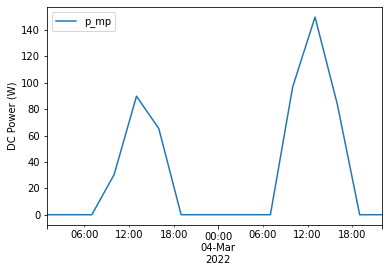

In [252]:
effective_irradiance = pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, 
                                                          airmass, aoi, sandia_module)

sapm_out = pvsystem.sapm(effective_irradiance, pvtemp, sandia_module)
#print(sapm_out.head())

sapm_out[['p_mp']].plot()
plt.ylabel('DC Power (W)');

In [253]:
solpos[['apparent_zenith','zenith','apparent_elevation']]

,apparent_zenith,zenith,apparent_elevation
2022-03-03 01:00:00+01:00,139.581302,139.581302,-49.581302
2022-03-03 04:00:00+01:00,123.165431,123.165431,-33.165431
2022-03-03 07:00:00+01:00,93.651357,93.651357,-3.651357
2022-03-03 10:00:00+01:00,66.011337,66.048834,23.988663
2022-03-03 13:00:00+01:00,54.032680,54.055823,35.967320
2022-03-03 16:00:00+01:00,68.019148,68.060398,21.980852
2022-03-03 19:00:00+01:00,96.247031,96.247031,-6.247031
2022-03-03 22:00:00+01:00,125.260966,125.260966,-35.260966
2022-03-04 01:00:00+01:00,139.195649,139.195649,-49.195649
2022-03-04 04:00:00+01:00,122.824778,122.824778,-32.824778


## AC power using SAPM

Get the inverter database from the web

In [254]:
sapm_inverters = pvsystem.retrieve_sam('sandiainverter')

Choose a particular inverter

In [255]:
sapm_inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
sapm_inverter

Vac                          208
Pso                     2.089607
Paco                       250.0
Pdco                  259.588593
Vdco                        40.0
C0                     -0.000041
C1                     -0.000091
C2                      0.000494
C3                     -0.013171
Pnt                        0.075
Vdcmax                      50.0
Idcmax                  6.489715
Mppt_low                    30.0
Mppt_high                   50.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__MICRO_0_25_I_OUTD_US_208__208V_, dtype: object

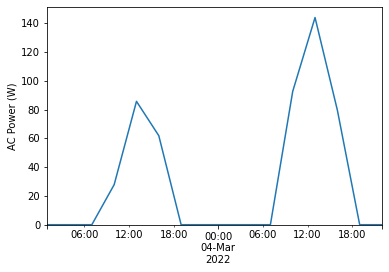

In [256]:
p_ac = inverter.sandia(sapm_out.v_mp, sapm_out.p_mp, sapm_inverter)
""" :sapm_out.v_mp 
        DC voltage input to the inverter. [V]

    sapm_out.p_mp 
        DC power input to the inverter."""
p_ac.plot()
plt.ylabel('AC Power (W)')
plt.ylim(0, None);

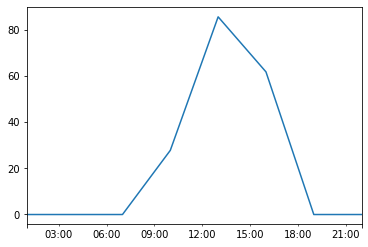

In [257]:
p_ac_day1 = p_ac[start:start+pd.Timedelta(days=1)]
p_ac_day1.plot()

In [258]:
import numpy as np
from scipy.optimize import curve_fit

def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)


x = np.arange(1,24,3)
y1 = np.asarray(p_ac_day1)
# mean = sum(x*y1)
# sigma = sum(y1*(x - mean)**2)
init_vals = [max(y1), 13,10] # for [amp, cen, wid]
# init_vals = [1,0,1] 
best_vals, covar = curve_fit(gaussian, x, y1 , p0= init_vals)


In [259]:
max(y1)

85.72703976356999

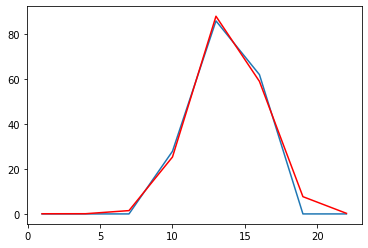

In [260]:
plt.plot(x,y1,)
plt.plot(x,gaussian(x,*best_vals),'r')
#plt.plot(x,gaussian(x,20,12.5,10))
plt.show()

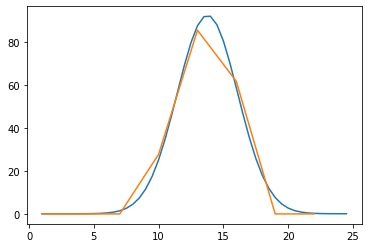

In [261]:

xhourly = np.arange(1,25,0.5)
plt.plot(xhourly, gaussian(xhourly,*best_vals))
plt.plot(x,y1,)
plt.show()

# Clearsky module from pvlib.location


Text(0.5, 1.0, 'Ineichen, climatological turbidity')

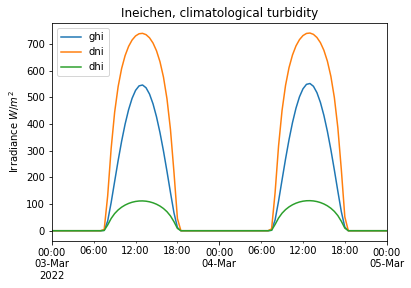

In [262]:
from pvlib.location import Location

tus = Location(latitude, longitude, tz, 200, 'Dijon FO')

times = pd.date_range(start='2022-03-03', end='2022-03-05', freq='30min', tz=tus.tz)

cs = tus.get_clearsky(times )

#plot de ghi
cs.plot()
plt.ylabel('Irradiance $W/m^2$')
plt.title('Ineichen, climatological turbidity')

In [263]:
solpos_cs = tus.get_solarposition(times)

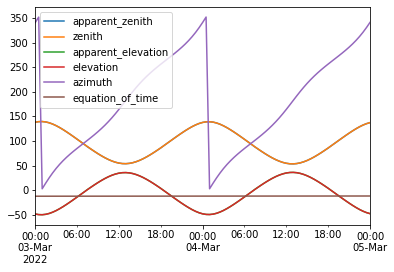

In [264]:
solpos_cs.plot()

In [265]:
dni_extra_cs = irradiance.get_extra_radiation(times)

dni_extra_cs

2022-03-03 00:00:00+01:00    1390.620322
2022-03-03 00:30:00+01:00    1390.620322
2022-03-03 01:00:00+01:00    1390.620322
2022-03-03 01:30:00+01:00    1390.620322
2022-03-03 02:00:00+01:00    1390.620322
                                ...     
2022-03-04 22:00:00+01:00    1389.902802
2022-03-04 22:30:00+01:00    1389.902802
2022-03-04 23:00:00+01:00    1389.902802
2022-03-04 23:30:00+01:00    1389.902802
2022-03-05 00:00:00+01:00    1389.178661
Freq: 30T, Length: 97, dtype: float64

Text(0, 0.5, 'Airmass')

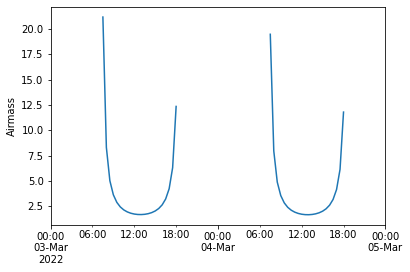

In [266]:
airmass_cs = atmosphere.get_relative_airmass(solpos_cs['apparent_zenith'])

airmass_cs.plot()
plt.ylabel('Airmass')

Text(0, 0.5, 'Irradiance ($W/m^{-2}$)')

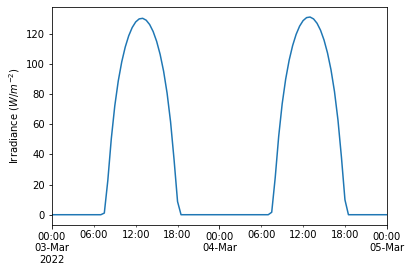

In [267]:
poa_sky_diffuse_cs = irradiance.haydavies(surface_tilt, surface_azimuth,
                                       cs['dhi'], cs['dni'], dni_extra_cs,
                                       solpos_cs['apparent_zenith'], solpos_cs['azimuth'])
poa_sky_diffuse_cs.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

Text(0, 0.5, 'Irradiance ($W/m^{-2}$)')

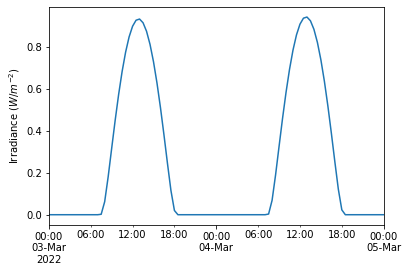

In [268]:
poa_ground_diffuse_cs = irradiance.get_ground_diffuse(surface_tilt, cs['ghi'], albedo=albedo)

poa_ground_diffuse_cs.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')

Text(0, 0.5, 'Angle of incidence (deg)')

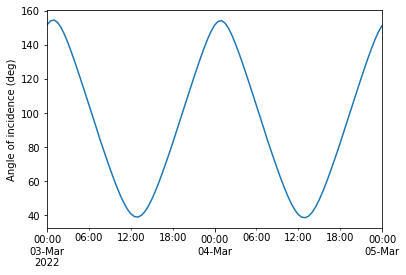

In [269]:
aoi_cs = irradiance.aoi(surface_tilt, surface_azimuth, solpos_cs['apparent_zenith'], solpos_cs['azimuth'])

aoi_cs.plot()
plt.ylabel('Angle of incidence (deg)')

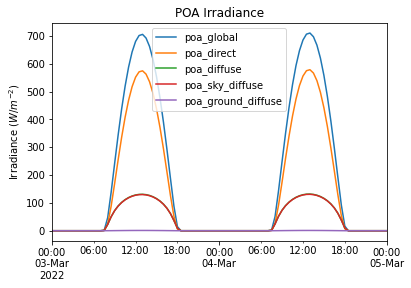

In [270]:
poa_irrad_cs = irradiance.poa_components(aoi_cs, cs['dni'], poa_sky_diffuse_cs, poa_ground_diffuse_cs)

poa_irrad_cs.plot()
plt.ylabel('Irradiance ($W/m^{-2}$)')
plt.title('POA Irradiance');

In [271]:
mean_temp = forecast_data['temp_air'].mean()
mean_temp

6.007200241088867

In [272]:
temp_cs = cs['ghi']
wndpeed_cs = cs['ghi']

In [273]:
for i in range (0,97):
  temp_cs[i]= mean_temp

In [274]:
temp_cs

2022-03-03 00:00:00+01:00    6.0072
2022-03-03 00:30:00+01:00    6.0072
2022-03-03 01:00:00+01:00    6.0072
2022-03-03 01:30:00+01:00    6.0072
2022-03-03 02:00:00+01:00    6.0072
                              ...  
2022-03-04 22:00:00+01:00    6.0072
2022-03-04 22:30:00+01:00    6.0072
2022-03-04 23:00:00+01:00    6.0072
2022-03-04 23:30:00+01:00    6.0072
2022-03-05 00:00:00+01:00    6.0072
Freq: 30T, Name: ghi, Length: 97, dtype: float64

In [275]:
mean_wind_speed  = forecast_data['wind_speed'].mean()
for i in range (0,97):
  wndpeed_cs[i] = mean_wind_speed

In [276]:
wndpeed_cs

2022-03-03 00:00:00+01:00    1.621523
2022-03-03 00:30:00+01:00    1.621523
2022-03-03 01:00:00+01:00    1.621523
2022-03-03 01:30:00+01:00    1.621523
2022-03-03 02:00:00+01:00    1.621523
                               ...   
2022-03-04 22:00:00+01:00    1.621523
2022-03-04 22:30:00+01:00    1.621523
2022-03-04 23:00:00+01:00    1.621523
2022-03-04 23:30:00+01:00    1.621523
2022-03-05 00:00:00+01:00    1.621523
Freq: 30T, Name: ghi, Length: 97, dtype: float64

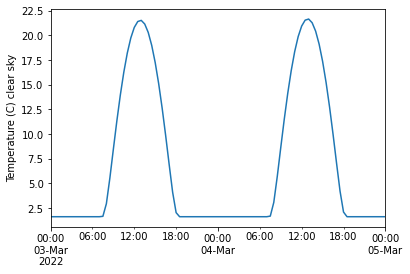

In [277]:
ambient_temperature_cs = temp_cs
wnd_spd_cs = wndpeed_cs
thermal_params = temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
pvtemp_cs = temperature.sapm_cell(poa_irrad_cs['poa_global'], temp_cs, wndpeed_cs, **thermal_params)

pvtemp_cs.plot()
plt.ylabel('Temperature (C) clear sky');

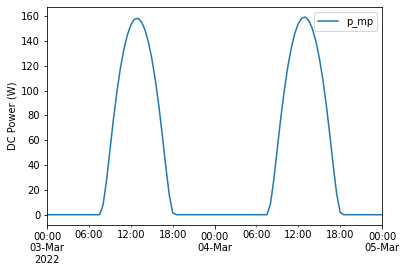

In [278]:
# AC power
sandia_modules_cs = pvsystem.retrieve_sam('SandiaMod')
sandia_module_cs = sandia_modules.Canadian_Solar_CS5P_220M___2009_
effective_irradiance_cs = pvsystem.sapm_effective_irradiance(poa_irrad_cs.poa_direct, poa_irrad_cs.poa_diffuse, 
                                                          airmass_cs, aoi_cs, sandia_module_cs)

sapm_out_cs = pvsystem.sapm(effective_irradiance_cs, pvtemp_cs, sandia_module_cs)

#print(sapm_out.head())

sapm_out_cs[['p_mp']].plot()
plt.ylabel('DC Power (W)');

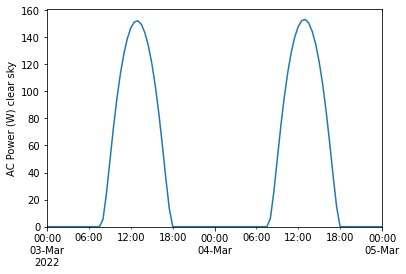

In [279]:
sapm_inverters = pvsystem.retrieve_sam('sandiainverter')
sapm_inverter_cs = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

p_ac_cs = inverter.sandia(sapm_out_cs.v_mp, sapm_out_cs.p_mp, sapm_inverter_cs)
""" :sapm_out.v_mp 
        DC voltage input to the inverter. [V]

    sapm_out.p_mp 
        DC power input to the inverter."""
p_ac_cs.plot()
plt.ylabel('AC Power (W) clear sky')
plt.ylim(0, None);

Text(0, 0.5, 'AC power')

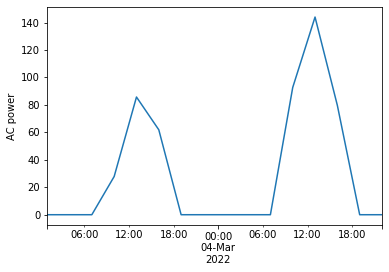

In [280]:
p_ac.plot()
plt.ylabel('AC power')

In [281]:
p_ac, p_ac_cs

(2022-03-03 01:00:00+01:00     -0.075000
 2022-03-03 04:00:00+01:00     -0.075000
 2022-03-03 07:00:00+01:00     -0.075000
 2022-03-03 10:00:00+01:00     27.779832
 2022-03-03 13:00:00+01:00     85.727040
 2022-03-03 16:00:00+01:00     61.838739
 2022-03-03 19:00:00+01:00     -0.075000
 2022-03-03 22:00:00+01:00     -0.075000
 2022-03-04 01:00:00+01:00     -0.075000
 2022-03-04 04:00:00+01:00     -0.075000
 2022-03-04 07:00:00+01:00     -0.075000
 2022-03-04 10:00:00+01:00     92.680615
 2022-03-04 13:00:00+01:00    144.030995
 2022-03-04 16:00:00+01:00     79.623222
 2022-03-04 19:00:00+01:00     -0.075000
 2022-03-04 22:00:00+01:00     -0.075000
 dtype: float64, 2022-03-03 00:00:00+01:00   -0.075
 2022-03-03 00:30:00+01:00   -0.075
 2022-03-03 01:00:00+01:00   -0.075
 2022-03-03 01:30:00+01:00   -0.075
 2022-03-03 02:00:00+01:00   -0.075
                              ...  
 2022-03-04 22:00:00+01:00   -0.075
 2022-03-04 22:30:00+01:00   -0.075
 2022-03-04 23:00:00+01:00   -0.075
 202

In [282]:
p_ac_cs.max(), p_ac.max()

(153.2040623017527, 144.0309948289408)

In [283]:
p_ac.index[1]

Timestamp('2022-03-03 04:00:00+0100', tz='Europe/Paris')

In [284]:
# diff = 0
# for i,date in enumerate(p_ac_cs.index):
#   if date in p_ac.index:
#     diff = p_ac_cs[date] - p_ac[date]
#     p_ac_cs[date]=p_ac[date]
#   else:
#     n = (i-2)//6
#     if n<15:
#       a= p_ac_cs[p_ac_cs.index[6*n + 2]] - p_ac[p_ac.index[n]]
#       b= p_ac_cs[p_ac_cs.index[6*n + 8]] - p_ac[p_ac.index[n+1]]
#       p_ac_cs[i] = p_ac_cs[i] - ((a+b)/2)


In [285]:
#calculer les rapports (pas de 3h)
rapports = []
for i,date in enumerate(p_ac_cs.index):
  if date in p_ac.index:
    if p_ac_cs[date]!= 0:
      rapports.append(p_ac[date]/p_ac_cs[date])
    else:
      rapports.append(1)


In [286]:
rapports

[1.0,
 1.0,
 1.0,
 0.29262790956907675,
 0.5630245991611473,
 0.7363799901663192,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9634736414282393,
 0.9401251681254736,
 0.937027338870843,
 1.0,
 1.0]

In [287]:
#interpoler les rapports (cubic)
import numpy as np
from scipy import interpolate

X = np.arange(0,96,6)
f = interpolate.interp1d(X,rapports, kind='cubic', fill_value = "extrapolate" )

X_new = np.arange(0,97,1)
rapports1 = f(X_new)

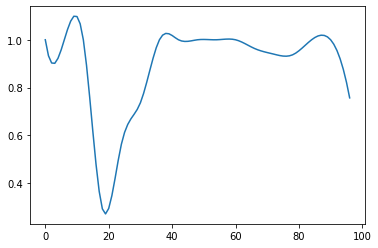

In [288]:
import matplotlib.pyplot as plt
plt.plot(X_new, rapports1)
plt.show()

In [307]:
import pandas as pd
rng = pd.date_range(start = start, end = end , freq='30T')
ac = pd.DataFrame({ 'Date': rng, 'Val': np.random.randn(len(rng)) })



In [308]:
rapports2 = pd.DataFrame({ 'Date': rng, 'Val': rapports1 })


In [309]:
for i, date in enumerate(rng):
  ac.loc[i, 'Val'] = p_ac_cs[date] * rapports1[i]


In [310]:
ac.head(5)

,Date,Val
0,2022-03-03 00:00:00+01:00,-0.075000
1,2022-03-03 00:30:00+01:00,-0.069988
2,2022-03-03 01:00:00+01:00,-0.067710
3,2022-03-03 01:30:00+01:00,-0.067619
4,2022-03-03 02:00:00+01:00,-0.069168


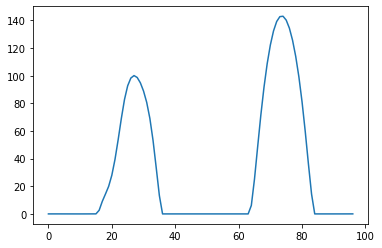

In [311]:
ac['Val'].plot()

In [293]:
rapports2

,Date,Val
0,2022-03-03 00:00:00+01:00,1.000000
1,2022-03-03 00:30:00+01:00,0.933176
2,2022-03-03 01:00:00+01:00,0.902801
3,2022-03-03 01:30:00+01:00,0.901586
4,2022-03-03 02:00:00+01:00,0.922241
...,...,...
92,2022-03-04 22:00:00+01:00,0.954887
93,2022-03-04 22:30:00+01:00,0.920121
94,2022-03-04 23:00:00+01:00,0.876104
95,2022-03-04 23:30:00+01:00,0.822002


In [294]:
rng

DatetimeIndex(['2022-03-03 00:00:00+01:00', '2022-03-03 00:30:00+01:00',
               '2022-03-03 01:00:00+01:00', '2022-03-03 01:30:00+01:00',
               '2022-03-03 02:00:00+01:00', '2022-03-03 02:30:00+01:00',
               '2022-03-03 03:00:00+01:00', '2022-03-03 03:30:00+01:00',
               '2022-03-03 04:00:00+01:00', '2022-03-03 04:30:00+01:00',
               '2022-03-03 05:00:00+01:00', '2022-03-03 05:30:00+01:00',
               '2022-03-03 06:00:00+01:00', '2022-03-03 06:30:00+01:00',
               '2022-03-03 07:00:00+01:00', '2022-03-03 07:30:00+01:00',
               '2022-03-03 08:00:00+01:00', '2022-03-03 08:30:00+01:00',
               '2022-03-03 09:00:00+01:00', '2022-03-03 09:30:00+01:00',
               '2022-03-03 10:00:00+01:00', '2022-03-03 10:30:00+01:00',
               '2022-03-03 11:00:00+01:00', '2022-03-03 11:30:00+01:00',
               '2022-03-03 12:00:00+01:00', '2022-03-03 12:30:00+01:00',
               '2022-03-03 13:00:00+01:00', '2022-0

In [295]:
for date in rng:
  a

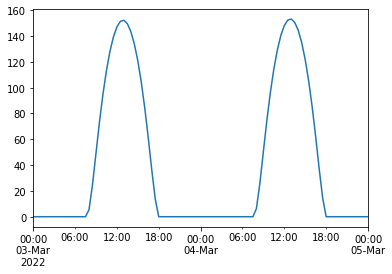

In [296]:
p_ac_cs.plot()

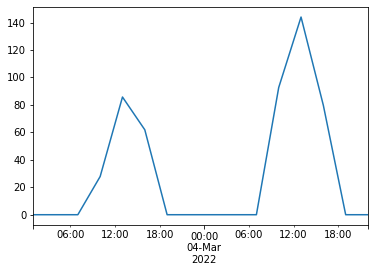

In [297]:
p_ac.plot()

In [298]:
for i,date in enumerate(p_ac_cs.index):
  if date not in p_ac.index:
    p_ac_cs[date] = p_ac_cs[date] - mean

NameError: ignored

In [ ]:
# p_ac_complet=[]
# for i in range(0,15):
#   p_ac_complet.append(0)

# power entre 7h et 10h
# coef = (list[2]+list[3])/2
# for i in range(15,20):
#   p_ac_complet.append(cs_list[i]-coef)

# # power à 10h
# p_ac_complet.append(p_ac_list[3])

# coef = (list[3]+list[4])/2
# for i in range(21,26):
#   p_ac_complet.append(cs_list[i]-coef)

# # à 13h
# p_ac_complet.append(p_ac_list[4])

# coef = (list[4]+list[5])/2
# for i in range(27,32):
#   p_ac_complet.append(cs_list[i]-coef)

# # à 16h
# for i in range(,15):
#   p_ac_complet.append(0)







In [ ]:
cs_list

In [ ]:
p_ac

In [ ]:
# integrate power to find energy yield over the forecast period
p_ac.sum() * 3

In [ ]:
len(p_ac_list)
x=np.arange(1,47,3)

from scipy import interpolate
f = interpolate.interp1d(x,p_ac_list, kind='cubic' )

In [ ]:
p_ac_list

In [ ]:
x

In [ ]:
x1 = np.arange(1,46.5,0.5)

y1 = f(x1)
y1

In [ ]:
plt.plot(x1,y1)
plt.show()